#0- Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords


# 1- Lading the data

In [ ]:
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ProjetML/data/scitweets_export.tsv', sep='\t')
df = pd.read_csv('/content/scitweets_export.tsv', sep='\t')


#2- Basic Iinfo

In [ ]:
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

Dataset shape: (1140, 7)

First few rows:
   Unnamed: 0            tweet_id  \
0           0  316669998137483264   
1           1  319090866545385472   
2           2  322030931022065664   
3           3  322694830620807168   
4           4  328524426658328576   

                                                text  science_related  \
0  Knees are a bit sore. i guess that's a sign th...                0   
1          McDonald's breakfast stop then the gym 🏀💪                0   
2  Can any Gynecologist with Cancer Experience ex...                1   
3  Couch-lock highs lead to sleeping in the couch...                1   
4  Does daily routine help prevent problems with ...                1   

   scientific_claim  scientific_reference  scientific_context  
0               0.0                   0.0                 0.0  
1               0.0                   0.0                 0.0  
2               1.0                   0.0                 0.0  
3               1.0                   0.

#3- Column info

In [ ]:
print("\nColumn dtypes:")
print(df.dtypes)


Column dtypes:
Unnamed: 0                int64
tweet_id                  int64
text                     object
science_related           int64
scientific_claim        float64
scientific_reference    float64
scientific_context      float64
dtype: object


#4- Missing values

In [ ]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Unnamed: 0              0
tweet_id                0
text                    0
science_related         0
scientific_claim        0
scientific_reference    0
scientific_context      0
dtype: int64


#5- Analyzing Class Distribution

##5.1- Task 1: SCI vs NON-SCI

In [ ]:
sci_counts = df['science_related'].value_counts()
print("\nTask 1 - SCI vs NON-SCI Distribution:")
print(sci_counts)
print(f"Percentage of science-related tweets: {100 * sci_counts[1] / len(df):.2f}%")


Task 1 - SCI vs NON-SCI Distribution:
science_related
0    765
1    375
Name: count, dtype: int64
Percentage of science-related tweets: 32.89%


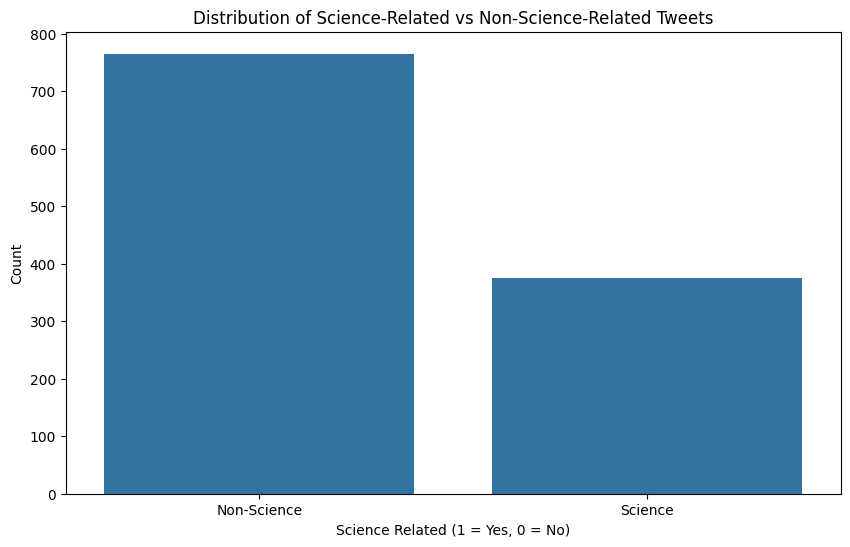

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='science_related', data=df)
plt.title('Distribution of Science-Related vs Non-Science-Related Tweets')
plt.xlabel('Science Related (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Science', 'Science'])
plt.savefig('/task1_distribution.png')
plt.show()


##5.2- Task 2: For science tweets, CLAIM,REF vs CONTEXT

In [ ]:
sci_tweets = df[df['science_related'] == 1].copy()
sci_tweets['claim_or_ref'] = ((sci_tweets['scientific_claim'] == 1) |
                             (sci_tweets['scientific_reference'] == 1)).astype(int)

print("\nTask 2 - CLAIM,REF vs CONTEXT Distribution (Science tweets only):")
print(sci_tweets['claim_or_ref'].value_counts())
print(f"Percentage of CLAIM or REF: {100 * sci_tweets['claim_or_ref'].mean():.2f}%")


Task 2 - CLAIM,REF vs CONTEXT Distribution (Science tweets only):
claim_or_ref
1    342
0     33
Name: count, dtype: int64
Percentage of CLAIM or REF: 91.20%


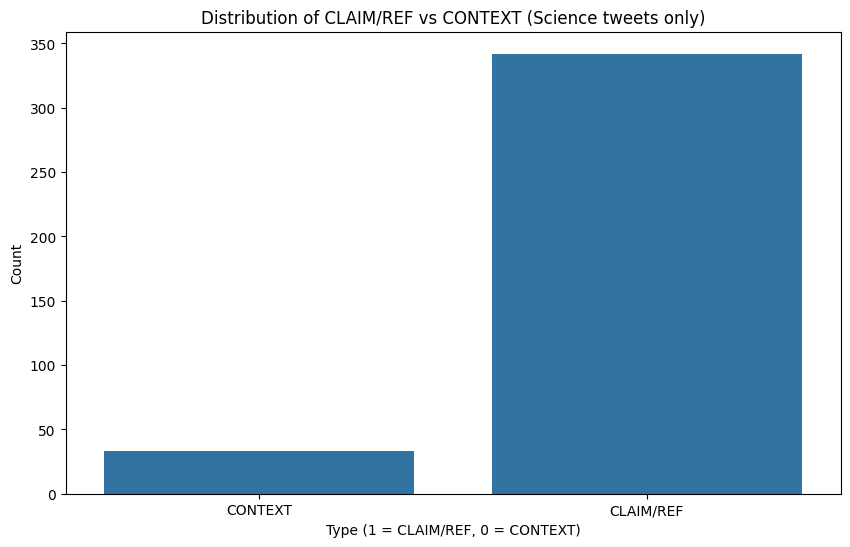

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='claim_or_ref', data=sci_tweets)
plt.title('Distribution of CLAIM/REF vs CONTEXT (Science tweets only)')
plt.xlabel('Type (1 = CLAIM/REF, 0 = CONTEXT)')
plt.ylabel('Count')
plt.xticks([0, 1], ['CONTEXT', 'CLAIM/REF'])
plt.savefig('/task2_distribution.png')
plt.show()

##5.3- Task 3: For science tweets, CLAIM vs REF vs CONTEXT

In [ ]:
# Create a category column
sci_tweets['category'] = 'CONTEXT'
sci_tweets.loc[sci_tweets['scientific_claim'] == 1, 'category'] = 'CLAIM'
sci_tweets.loc[sci_tweets['scientific_reference'] == 1, 'category'] = 'REF'

In [ ]:
# Check for multi-label cases
multi_label = ((sci_tweets['scientific_claim'] + sci_tweets['scientific_reference'] +
                sci_tweets['scientific_context']) > 1).sum()
print(f"\nNumber of tweets with multiple labels: {multi_label}")

print("\nTask 3 - CLAIM vs REF vs CONTEXT Distribution (Science tweets only):")
print(sci_tweets['category'].value_counts())



Number of tweets with multiple labels: 218

Task 3 - CLAIM vs REF vs CONTEXT Distribution (Science tweets only):
category
REF        203
CLAIM      139
CONTEXT     33
Name: count, dtype: int64


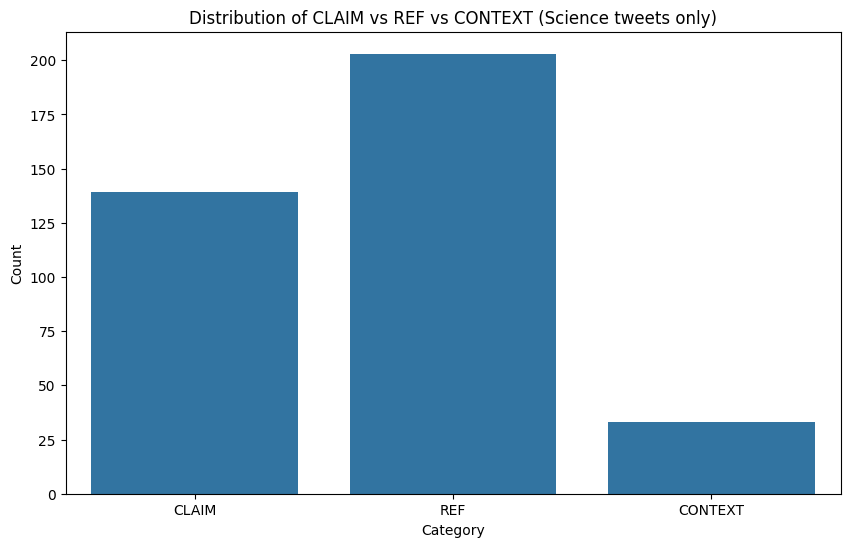

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=sci_tweets)
plt.title('Distribution of CLAIM vs REF vs CONTEXT (Science tweets only)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.savefig('/task3_distribution.png')
plt.show()

#6- Analyzing Tweet Characteristics

##6.1 Add tweet length as a feature

In [ ]:
df['tweet_length'] = df['text'].apply(len)
sci_tweets['tweet_length'] = sci_tweets['text'].apply(len)

##6.2- Analyzing Tweet length

In [ ]:
print("\nTweet Length Statistics:")
print(df['tweet_length'].describe())


Tweet Length Statistics:
count    1140.000000
mean      137.011404
std        69.907093
min        14.000000
25%        93.000000
50%       126.000000
75%       156.000000
max       777.000000
Name: tweet_length, dtype: float64


##6.3- Compare length by category

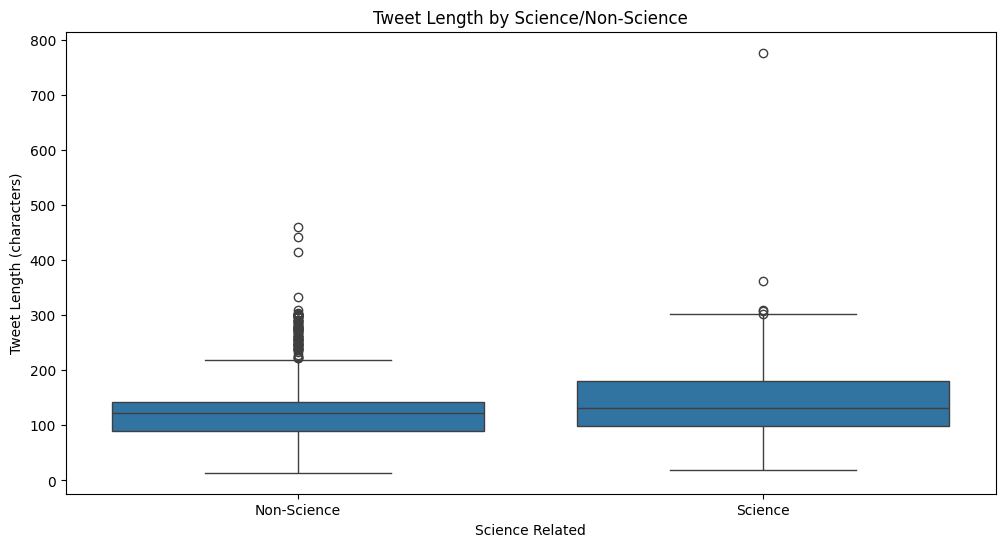

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='science_related', y='tweet_length', data=df)
plt.title('Tweet Length by Science/Non-Science')
plt.xlabel('Science Related')
plt.xticks([0, 1], ['Non-Science', 'Science'])
plt.ylabel('Tweet Length (characters)')
plt.savefig('/tweet_length_by_science.png')
plt.show()

##6.4- For science tweets, compare length by category

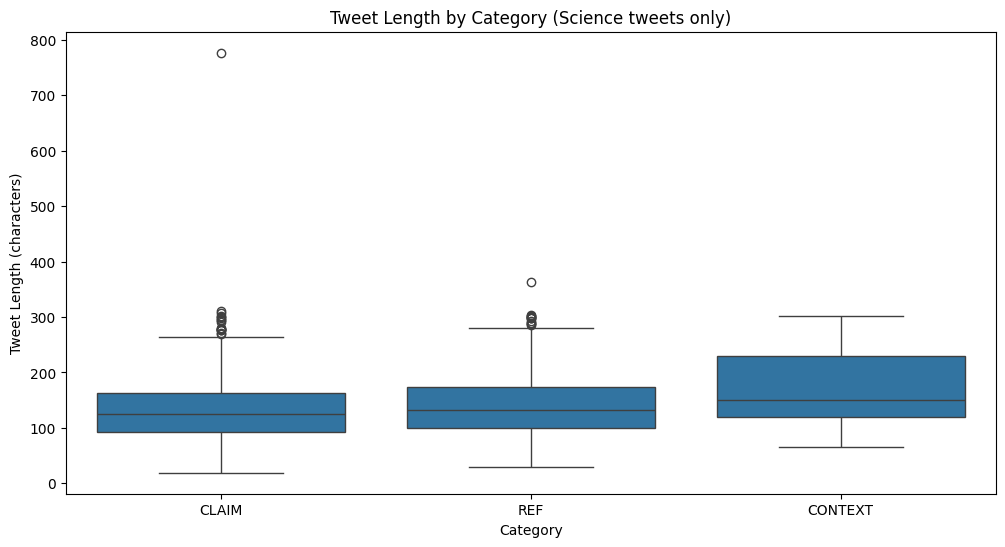

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='tweet_length', data=sci_tweets)
plt.title('Tweet Length by Category (Science tweets only)')
plt.xlabel('Category')
plt.ylabel('Tweet Length (characters)')
plt.savefig('/tweet_length_by_category.png')
plt.show()

##6.5- Count URLs Hashtags mentions

In [ ]:
def count_features(text):
    url_count = len(re.findall(r'http\S+|www\.\S+', text))
    hashtag_count = len(re.findall(r'#\w+', text))
    mention_count = len(re.findall(r'@\w+', text))
    return url_count, hashtag_count, mention_count

In [ ]:
df['url_count'], df['hashtag_count'], df['mention_count'] = zip(*df['text'].apply(count_features))

In [ ]:
# Analyze presence of URLs, hashtags, mentions by category
print("\nAverage URLs, Hashtags, Mentions by Science/Non-Science:")
print(df.groupby('science_related')[['url_count', 'hashtag_count', 'mention_count']].mean())


Average URLs, Hashtags, Mentions by Science/Non-Science:
                 url_count  hashtag_count  mention_count
science_related                                         
0                 0.675817       0.669281       0.713725
1                 1.026667       0.586667       0.576000


In [ ]:
# For science tweets
sci_tweets['url_count'], sci_tweets['hashtag_count'], sci_tweets['mention_count'] = zip(*sci_tweets['text'].apply(count_features))

print("\nAverage URLs, Hashtags, Mentions by Category (Science tweets only):")
print(sci_tweets.groupby('category')[['url_count', 'hashtag_count', 'mention_count']].mean())


Average URLs, Hashtags, Mentions by Category (Science tweets only):
          url_count  hashtag_count  mention_count
category                                         
CLAIM      0.669065       0.568345       0.676259
CONTEXT    1.121212       0.909091       1.181818
REF        1.256158       0.546798       0.408867


#7- Word Frequency Analysis

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##7.1- Most Common Words

In [ ]:
def get_common_words(texts, top_n=30, min_word_length=3):
    stop_words = set(stopwords.words('english'))
    words = []

    for text in texts:
        # Convert to lowercase and tokenize
        tokens = nltk.word_tokenize(text.lower())
        # Remove stopwords and short words
        filtered_tokens = [word for word in tokens if word not in stop_words and
                         len(word) >= min_word_length and word.isalpha()]
        words.extend(filtered_tokens)

    return Counter(words).most_common(top_n)

In [ ]:
# Get common words by category
science_words = get_common_words(df[df['science_related'] == 1]['text'])
non_science_words = get_common_words(df[df['science_related'] == 0]['text'])

print("\nMost common words in Science tweets:")
for word, count in science_words:
    print(f"{word}: {count}")

print("\nMost common words in Non-Science tweets:")
for word, count in non_science_words:
    print(f"{word}: {count}")


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
# For science tweets by category
claim_words = get_common_words(sci_tweets[sci_tweets['category'] == 'CLAIM']['text'])
ref_words = get_common_words(sci_tweets[sci_tweets['category'] == 'REF']['text'])
context_words = get_common_words(sci_tweets[sci_tweets['category'] == 'CONTEXT']['text'])

print("\nMost common words in CLAIM tweets:")
for word, count in claim_words[:15]:
    print(f"{word}: {count}")

print("\nMost common words in REF tweets:")
for word, count in ref_words[:15]:
    print(f"{word}: {count}")

print("\nMost common words in CONTEXT tweets:")
for word, count in context_words[:15]:
    print(f"{word}: {count}")

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


#8- Creating word Clouds

In [ ]:
def create_wordcloud(texts, title, filename):
    stop_words = set(stopwords.words('english'))
    all_text = ' '.join(texts)

    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=stop_words,
        max_words=100,
        collocations=False
    ).generate(all_text)

    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.savefig(f'/{filename}.png')
    plt.show()

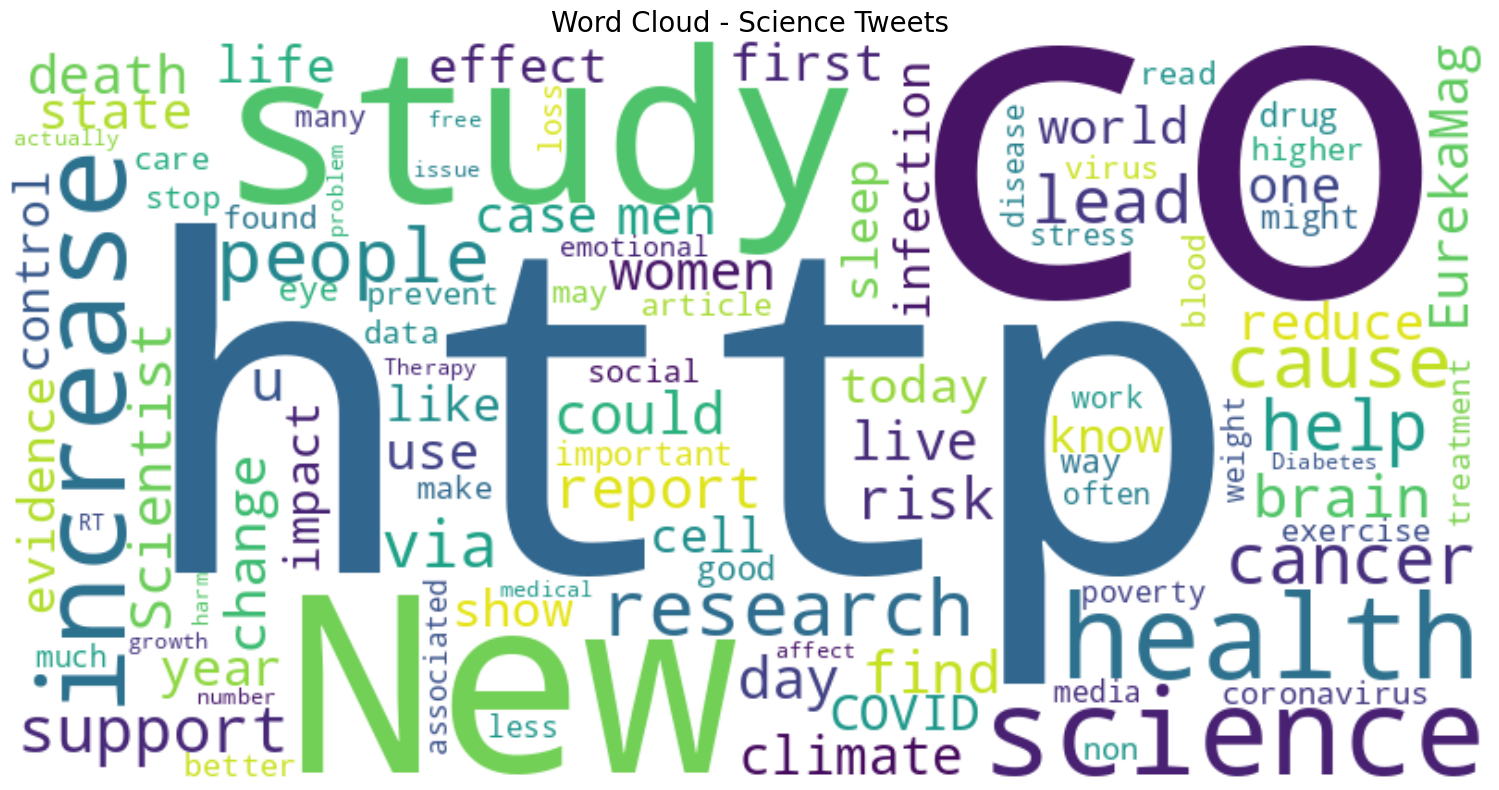

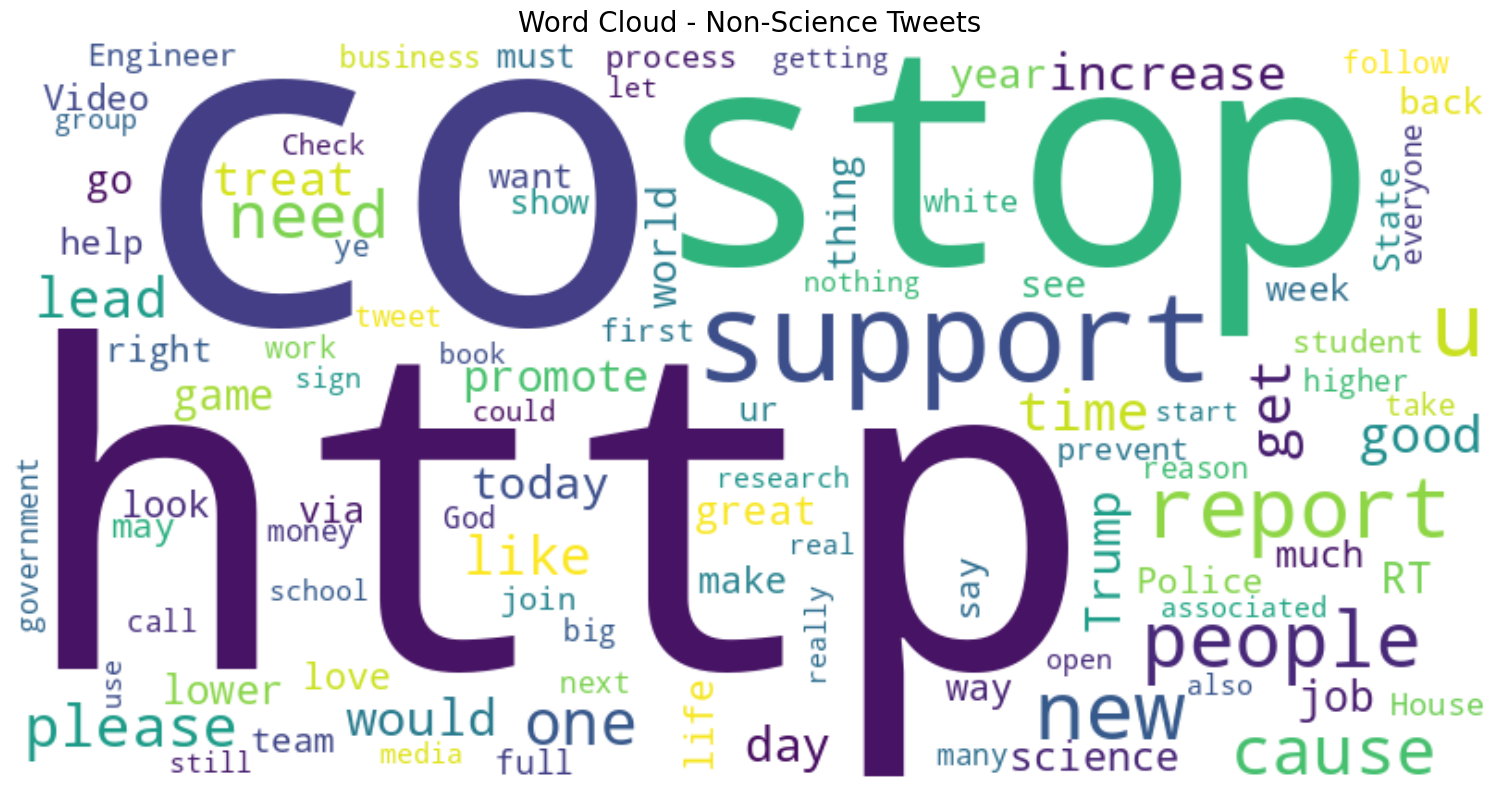

In [ ]:
# Create word clouds for Science vs Non-Science
create_wordcloud(df[df['science_related'] == 1]['text'], 'Word Cloud - Science Tweets', 'wordcloud_science')
create_wordcloud(df[df['science_related'] == 0]['text'], 'Word Cloud - Non-Science Tweets', 'wordcloud_nonscience')


In [ ]:
# Create word clouds for each category in science tweets
create_wordcloud(sci_tweets[sci_tweets['category'] == 'CLAIM']['text'], 'Word Cloud - CLAIM Tweets', 'wordcloud_claim')
create_wordcloud(sci_tweets[sci_tweets['category'] == 'REF']['text'], 'Word Cloud - REF Tweets', 'wordcloud_ref')
create_wordcloud(sci_tweets[sci_tweets['category'] == 'CONTEXT']['text'], 'Word Cloud - CONTEXT Tweets', 'wordcloud_context')

Output hidden; open in https://colab.research.google.com to view.

#9- Checking class imbalance

##9.1- Task 1: SCI vs NON-SCI balance

In [ ]:
sci_ratio = sci_counts[1] / len(df)
print(f"\nTask 1 - SCI vs NON-SCI balance:")
print(f"Science tweets ratio: {sci_ratio:.4f}")
print(f"Class imbalance ratio: {max(sci_ratio, 1-sci_ratio) / min(sci_ratio, 1-sci_ratio):.2f}")
if max(sci_ratio, 1-sci_ratio) / min(sci_ratio, 1-sci_ratio) > 2:
    print("This task has a significant class imbalance and may require balancing techniques.")


Task 1 - SCI vs NON-SCI balance:
Science tweets ratio: 0.3289
Class imbalance ratio: 2.04
This task has a significant class imbalance and may require balancing techniques.


##9.2- # Task 2: CLAIM,REF vs CONTEXT balance (science tweets only)

In [ ]:
claim_ref_ratio = sci_tweets['claim_or_ref'].mean()
print(f"\nTask 2 - CLAIM,REF vs CONTEXT balance:")
print(f"CLAIM/REF ratio: {claim_ref_ratio:.4f}")
print(f"Class imbalance ratio: {max(claim_ref_ratio, 1-claim_ref_ratio) / min(claim_ref_ratio, 1-claim_ref_ratio):.2f}")
if max(claim_ref_ratio, 1-claim_ref_ratio) / min(claim_ref_ratio, 1-claim_ref_ratio) > 2:
    print("This task has a significant class imbalance and may require balancing techniques.")



Task 2 - CLAIM,REF vs CONTEXT balance:
CLAIM/REF ratio: 0.9120
Class imbalance ratio: 10.36
This task has a significant class imbalance and may require balancing techniques.


##9.3- Task 3: CLAIM vs REF vs CONTEXT balance (science tweets only)

In [ ]:
category_counts = sci_tweets['category'].value_counts()
print(f"\nTask 3 - CLAIM vs REF vs CONTEXT balance:")
print(category_counts)
max_count = category_counts.max()
min_count = category_counts.min()
print(f"Max/Min ratio: {max_count / min_count:.2f}")
if max_count / min_count > 2:
    print("This task has a significant class imbalance and may require balancing techniques.")


Task 3 - CLAIM vs REF vs CONTEXT balance:
category
REF        203
CLAIM      139
CONTEXT     33
Name: count, dtype: int64
Max/Min ratio: 6.15
This task has a significant class imbalance and may require balancing techniques.


#10- Analyzing Co-occurrence features

##10.1- Create a correlation heatmap

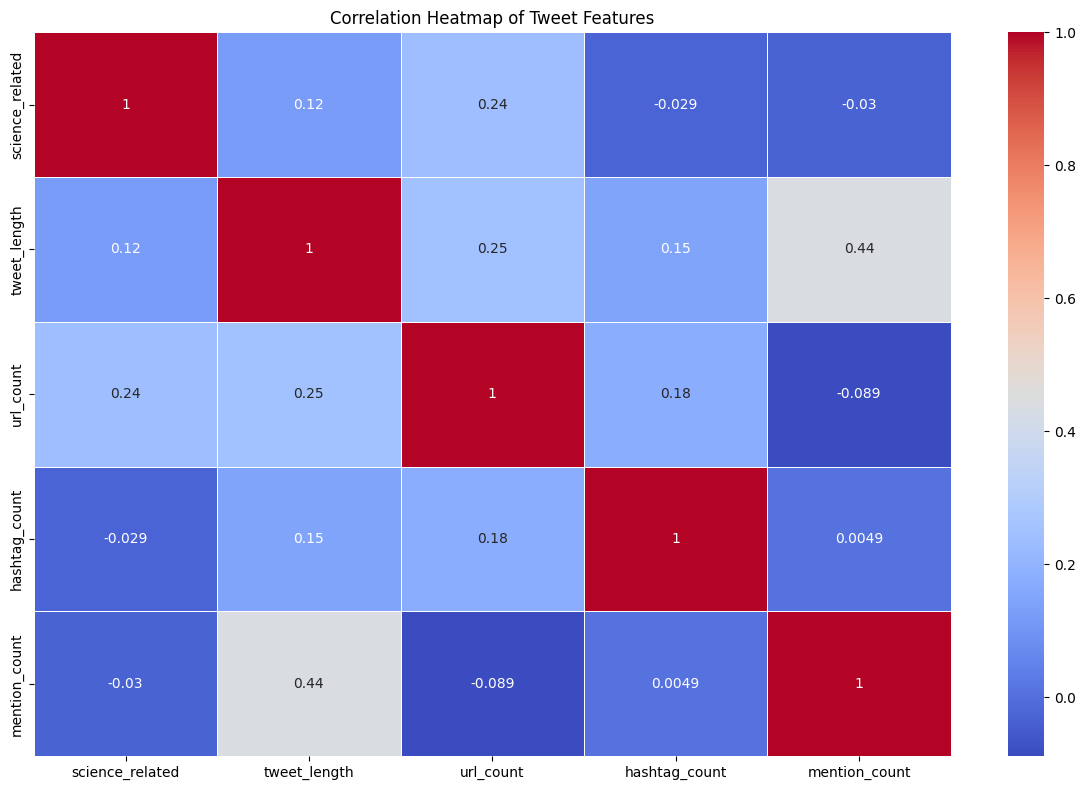

In [ ]:

plt.figure(figsize=(12, 8))
correlation_matrix = df[['science_related', 'tweet_length', 'url_count', 'hashtag_count', 'mention_count']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Tweet Features')
plt.tight_layout()
plt.savefig('/correlation_heatmap.png')
plt.show()

##10.2- # For science tweets


In [ ]:
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

##10.3- Convert categorical ro numeric

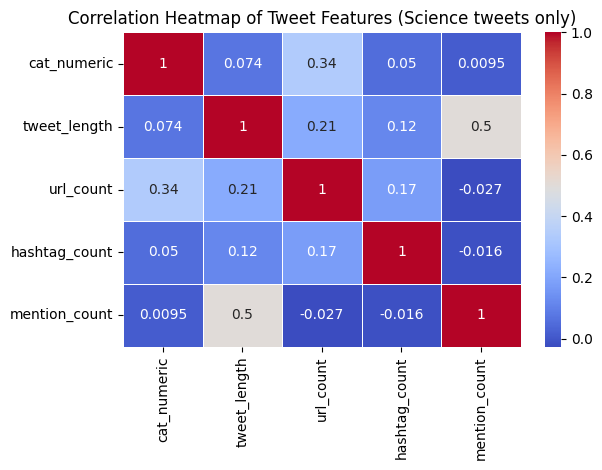

In [ ]:
sci_tweets['cat_numeric'] = sci_tweets['category'].map({'CLAIM': 0, 'REF': 1, 'CONTEXT': 2})
correlation_matrix = sci_tweets[['cat_numeric', 'tweet_length', 'url_count', 'hashtag_count', 'mention_count']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Tweet Features (Science tweets only)')
plt.tight_layout()
plt.savefig('/correlation_heatmap_science.png')
plt.show()

#11- Summary

In [ ]:
print("\n=== SUMMARY OF DATA EXPLORATION ===")
print(f"Total tweets: {len(df)}")
print(f"Science-related tweets: {sum(df['science_related'] == 1)} ({100 * sci_ratio:.2f}%)")
print(f"Non-science tweets: {sum(df['science_related'] == 0)} ({100 * (1-sci_ratio):.2f}%)")

print("\nFor science-related tweets:")
for category, count in category_counts.items():
    print(f"- {category}: {count} ({100 * count / len(sci_tweets):.2f}%)")

print("\nKey observations:")
print("1. [Add your observations about class distribution]")
print("2. [Add your observations about tweet characteristics]")
print("3. [Add your observations about vocabulary differences]")
print("4. [Add your observations about potential challenges]")

print("\nRecommendations for preprocessing:")
print("1. [Add your recommendations based on findings]")
print("2. [Add your recommendations for handling class imbalance if present]")
print("3. [Add your recommendations for feature engineering]")


=== SUMMARY OF DATA EXPLORATION ===
Total tweets: 1140
Science-related tweets: 375 (32.89%)
Non-science tweets: 765 (67.11%)

For science-related tweets:
- REF: 203 (54.13%)
- CLAIM: 139 (37.07%)
- CONTEXT: 33 (8.80%)

Key observations:
1. [Add your observations about class distribution]
2. [Add your observations about tweet characteristics]
3. [Add your observations about vocabulary differences]
4. [Add your observations about potential challenges]

Recommendations for preprocessing:
1. [Add your recommendations based on findings]
2. [Add your recommendations for handling class imbalance if present]
3. [Add your recommendations for feature engineering]
